# The latent cognitive structures of social networks code tutorial
This notebook was written to accompany the manuscript _The latent cognitive structures of social networks_ (Aguiar, Ugander 2023). Here, we introduce and explain code from the work and document finding the NNTuck of the advice CSS from Krackhardt (1987). 

This notebook depends on `numpy`, `tensorly`, `sklearn`, and `matplotlib`. When sweeping over parameters $K$ and $C$ in NNTuck it is most efficient to run the sweep in parallel, which depends on `joblib` and on `os` to make sure the parallel runs don't use too much CPU. In this tutorial we only sweep over one possible combination of parameters $(K,C)$, but the code is still written in parallel to easily adapt for a more comprehensive sweep. Specific version numbers for which this code runs are in the readme.

Please email me at `izzya@stanford.edu` with _any_ questions at all about this tutorial or the code associated with it!

### Import libraries and external definitions

In [1]:
import NNTucktools
import numpy as np
from NNTucktools import non_negative_tucker, non_negative_tucker_SCagreement, non_negative_tucker_ones, KL_D, max_like, GenerateSBM, Y_interp
import tensorly as tl
from sklearn.metrics import roc_auc_score
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.base import unfold
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed
from matplotlib.ticker import MaxNLocator
from tensorly.tenalg import mode_dot
import scipy
import copy
import pyreadr
import networkx as nx
import ast

### Load the adjacency tensors
For this code tutorial we focus on the CSS dataset from [Krackhardt (1987)](https://bebr.ufl.edu/sites/default/files/Cognitive%20Social%20Strucutres.pdf), and HUNTER.

In [3]:
from numpy import genfromtxt
krack = np.zeros((21,21,21))
for j in range(1,22):
    p = str(j)
    filename = 'krackhardt_data/krack_' + p + '.csv'
    krack_temp = genfromtxt(filename, delimiter=',')
    krack[j-1, :, :] = krack_temp

In [16]:
krack_f = np.load('krack_friend.npy')
krack_a = np.load('krack_advice.npy')
krackf_and = np.sum(krack_f, axis = 0)
krackf_and[np.where(krackf_and > 1)] = 1
krackf_Network = nx.from_numpy_array(krackf_and)
posf = nx.spring_layout(krackf_Network, k=0.05)
kracka_and = np.sum(krack_a, axis = 0)
kracka_and[np.where(kracka_and > 1)] = 1
kracka_Network = nx.from_numpy_array(kracka_and)

In [4]:
from numpy import loadtxt
N = 20
W = 6
hunter_f = np.zeros((W, N, N, N))
hunter_a = np.zeros((W, N, N, N))

p = str(1)
ad_filename = 'Hunter_Data/Friendship_Week_' + p + '.csv'
friend_bf = loadtxt(ad_filename, delimiter=',', dtype = str)
IDs = [int(friend_bf[0][i]) for i in range(5,25)]
race = [[], [], [], [], [] ,[]]
gender = [[],[]]
g_code = ['M', 'F']
r_code = ['BLACK', 'HISPN', 'ASIAN', 'MULTI', 'AM-IND', 'WHITE']
seen = []
for row in range(1, len(friend_bf)):
    person = int(friend_bf[row][3])
    person_ID = IDs.index(person)
    if person not in seen:
        g = g_code.index(friend_bf[row][0])
        r = r_code.index(friend_bf[row][1])
        gender[g].append(person_ID)
        race[r].append(person_ID,)
        seen.append(person)
for w in range(1, W+1):
    p = str(w)
    ad_filename = 'Hunter_Data/Advice_Week_' + p + '.csv'
    fr_filename = 'Hunter_Data/Friendship_Week_' + p + '.csv'
    advice_bf = loadtxt(ad_filename, delimiter=',', dtype = str)
    friend_bf = loadtxt(fr_filename, delimiter=',', dtype = str)

    for row in range(1, len(advice_bf)):
        ad_imp = [int(advice_bf[row][i]) for i in range(3,25)]
        layer = IDs.index(ad_imp[0])
        ego = IDs.index(ad_imp[1])
        hunter_a[w-1][layer][ego, :] = ad_imp[2:]

    for row in range(1, len(friend_bf)):
        fr_imp = [int(friend_bf[row][i]) for i in range(3,25)]
        layer = IDs.index(fr_imp[0])
        ego = IDs.index(fr_imp[1])
        hunter_f[w-1][layer][ego, :] = fr_imp[2:]

In [74]:
friend_truth_6 = loadtxt('Hunter_Data/Friends_Truth_Week_6.csv', delimiter=',', dtype = int)
advice_truth_6 = loadtxt('Hunter_Data/Advice_Truth_Week_6.csv', delimiter=',', dtype = int)
ad_network = nx.from_numpy_array(advice_truth_6)
fr_network = nx.from_numpy_array(friend_truth_6)
pos = {0: np.array([0.14398204, 0.67120675]),
 1: np.array([0.11839553, 0.26975363]),
 2: np.array([-0.59528823,  0.84744776]),
 3: np.array([-0.54738963,  0.25365929]),
 4: np.array([ 0.84802732, -0.27560054]),
 5: np.array([ 0.28470199, -0.44132085]),
 6: np.array([-0.01455318,  0.06581902]),
 7: np.array([0.96565727, 0.25386217]),
 8: np.array([-0.15665468, -0.41470634]),
 9: np.array([ 0.27006541, -0.73735467]),
 10: np.array([-0.32606193,  0.43905169]),
 11: np.array([-0.44885761,  0.08847577]),
 12: np.array([-0.3465751 , -0.28759149]),
 13: np.array([-0.2469192,  0.7447331]),
 14: np.array([-0.53589258, -0.23669964]),
 15: np.array([-0.18453015,  0.19998342]),
 16: np.array([ 0.06178715, -0.33538839]),
 17: np.array([ 0.0094389, -1.       ]),
 18: np.array([ 0.51389975, -0.1663787 ]),
 19: np.array([0.18676692, 0.06104802])}

In [5]:
kracknets = pyreadr.read_r('kracknets.rda')

depts = np.array(kracknets['attributes']['DEPT'])
tenure = np.array(kracknets['attributes']['TENURE'])
age = np.array(kracknets['attributes']['AGE'])
level = np.array(kracknets['attributes']['LEVEL'])

kracknetrepnp = np.array(kracknets['reports_to_data_frame'])
kracknetrepnp[:, (0,1)] = kracknetrepnp[:, (0,1)] - 1

kracknet_report_adj = np.zeros((21,21))
for l in range(441):
    i = kracknetrepnp[l][0]
    j = kracknetrepnp[l][1]
    k = kracknetrepnp[l][2]
    kracknet_report_adj[i,j] = k

In [6]:
posrep = {0: np.array([ 0.36704917, -0.87309407]),
 1: np.array([ 0.25198734, -0.53055533]),
 2: np.array([-0.89587249, -0.19925205]),
 3: np.array([ 0.51139739, -0.70950406]),
 4: np.array([-0.53020225, -0.28623758]),
 5: np.array([0.95174082, 0.30093429]),
 6: np.array([0.08891742, 0.01561021]),
 7: np.array([0.78723949, 0.42963133]),
 8: np.array([-0.8475622 ,  0.10490396]),
 9: np.array([0.23667186, 0.81803294]),
 10: np.array([0.00744397, 0.83504216]),
 11: np.array([1.        , 0.10694856]),
 12: np.array([-0.83146648,  0.27821425]),
 13: np.array([-0.58488428, -0.00903106]),
 14: np.array([-0.59108917,  0.28617441]),
 15: np.array([ 0.14753465, -0.83684102]),
 16: np.array([ 0.87820785, -0.06696584]),
 17: np.array([0.10584601, 0.51693399]),
 18: np.array([-0.74074995, -0.30333086]),
 19: np.array([-0.9704296 , -0.01727718]),
 20: np.array([0.65822045, 0.13966293])}
#nx.spring_layout(krack_Network_report, k=0.1)#, pos = {17: np.array([])})

In [7]:
krack_las = np.zeros((21,21))
for i in range(21):
    for j in range(21):
        krack_las[i, j]= krack[i, i, j]
krack_and = np.sum(krack, axis = 0)
krack_and[np.where(krack_and < 1)] = 0
krack_and[np.where(krack_and >= 1)] = 1

krack_CS = np.sum(krack, axis = 0)
krack_CS[np.where(krack_CS < 10.5)] = 0
krack_CS[np.where(krack_CS >= 10.5)] = 1

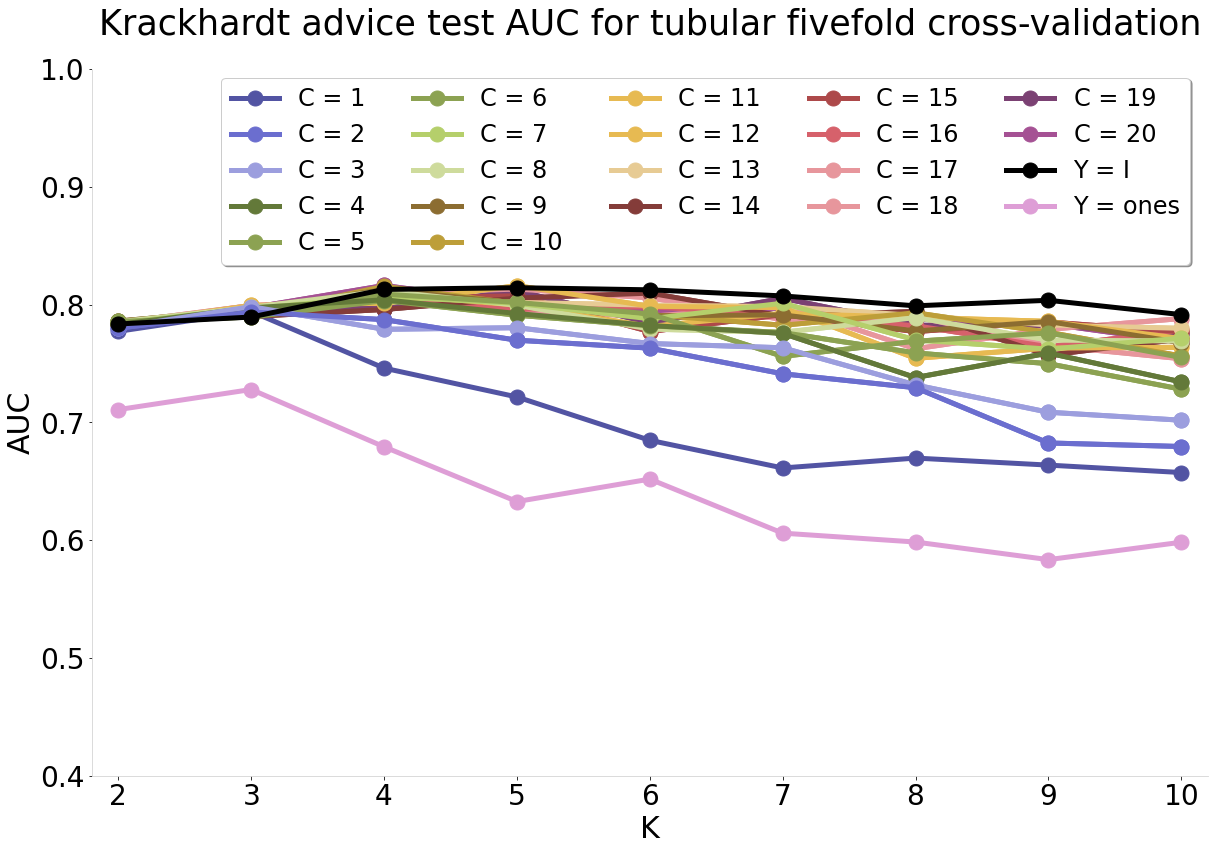

In [172]:
avg_AUCs_krack_chunka = np.load('avg_AUCs_krack_chunka.npy')
avg_krack_ones_AUCa_chunk = np.load('avg_krack_ones_AUCa_chunk.npy')

c_list = [1, 3, 6, 9, 12]
f, axis = plt.subplots(1,1)
f.set_figheight(13)
f.set_figwidth(20)
colormap = plt.cm.tab20b #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1, 25)]
c_s = ['I', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
for ell in range(2,22):
    col = colors[ell]
    axis.plot(range(2,11),avg_AUCs_krack_chunka[:, ell-1], lw = 5, marker='o', markersize= 15, c=col, label = 'C = {}'.format(c_s[ell-1]))
    #axis.hlines(avg_AUCs_Ala_iid[ell-2, 0], 1, 12, lw = 2, ls = 'dotted', color=col)
    
for ell in range(21, 2, -1):
    col = colors[ell]
    axis.plot(range(2,11),avg_AUCs_krack_chunka[:, ell-1], lw = 5, marker='o', markersize= 15, c=col)
    #axis.hlines(avg_AUCs_Ala_iid[ell-2, 0], 1, 12, lw = 2, ls = 'dotted', color=col)
axis.plot(range(2,11),avg_AUCs_krack_chunka[:, 0], lw = 5, marker='o', markersize= 15, c='k', label = 'Y = {}'.format(c_s[0]))

    
axis.set_ylim(0.4, 1)
axis.set_xlim(1.8, 10.2)
axis.xaxis.set_major_locator(MaxNLocator(integer=True))
axis.plot(range(2,11), avg_krack_ones_AUCa_chunk, lw = 5, marker='o', markersize= 15, c=colors[-2], label = 'Y = ones')
#axis.legend(fontsize = 24, loc='upper center', bbox_to_anchor=(0.55, .95),
          #ncol=5, fancybox=True, shadow=True)
axis.legend(fontsize = 24, loc='upper center', bbox_to_anchor=(0.55, 1.005),
          ncol=5, fancybox=True, shadow=True)
axis.set_xlabel('K', fontsize=30)
axis.set_ylabel('AUC', fontsize=30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
axis.spines['bottom'].set_color('lightgrey')
axis.spines['top'].set_color('white')
axis.spines['left'].set_color('lightgrey')
axis.spines['right'].set_color('white')
axis.set_title('Krackhardt advice test AUC for tubular fivefold cross-validation',fontsize=35, pad=35)
# axis.legend(fontsize = 24, loc='upper center', bbox_to_anchor=(0.55, .995),
#           ncol=5, fancybox=True, shadow=True)
plt.savefig('kracka_chunk_sweep_legend.pdf', pad_inches=0.05)

## Estimating an NNTuck 


In [8]:
def multistart(tensor, C, K, masked, Mask, Sym, NUM_IT, ms_type = 'reg'):
    if masked:
        assert np.shape(tensor) == np.shape(Mask), "size of tensor and Mask must be the same"
    if ms_type == 'Ind':
        return multi_nntuck_ind(tensor, C, K, masked, Mask, Sym, NUM_IT)
    elif ms_type == 'Red':
        assert C == 1, "for a Redundant NNTuck, C must be equal to 1"
        return multi_nntuck_ones(tensor, C, K, masked, Mask, Sym, NUM_IT)
    elif ms_type == 'SCA':
        assert C == K, "for a Redundant NNTuck, C must be equal to K"
        return multi_nntuck_sca(tensor, K, K, masked, Mask, Sym, NUM_IT)
    elif ms_type == 'reg':
        return multi_nntuck(tensor, C, K, masked, Mask, Sym, NUM_IT)
    else:
        print("ms_type must be one of: Ind, Red, SCA, reg")
        return
    
def multi_nntuck_ones(tensor, C, K, masked = False, Mask = None, Sym = False, NUM_IT = 20):
    ALPHA, N, N = np.shape(tensor)
        
    tuck, logl, kld = non_negative_tucker_ones(tensor, rank = [C, K, K], init='random', n_iter_max=1000,
                                                                 symmetric = Sym, masked = masked, Masking = Mask,
                                                          MT_stopping_conditions = True, returnErrors = True,
                                                            verbose=False, constrained=True, loss = 'KL', tol=10e-6)
    max_logl = logl[-1]
    max_tuck = tuck
    max_kld = kld[-1]

    for i in range(1, NUM_IT):
        tuck, logl, kld = non_negative_tucker_ones(tensor, rank = [C, K, K], init='random', n_iter_max=1000,
                                                                 symmetric = Sym, masked = masked, Masking = Mask,
                                                          MT_stopping_conditions = True, returnErrors = True,
                                                            verbose=False, constrained=True, loss = 'KL', tol=10e-6)
        if logl[-1] > max_logl: 
            max_logl = logl[-1]
            max_tuck = tuck
            max_kld = kld[-1]

    core, factors = max_tuck
    return core, factors, max_logl

def multi_nntuck_ind(tensor, C, K, masked = False, Mask = None, Sym = False, NUM_IT = 20):
    ALPHA, N, N = np.shape(tensor)
        
    tuck, logl, kld = non_negative_tucker(tensor, rank = [ALPHA, K, K], init='random', n_iter_max=1000,
                                                                 symmetric = Sym, masked = masked, Masking = Mask,
                                                          MT_stopping_conditions = True, returnErrors = True,
                                                            verbose=False, constrained=True, loss = 'KL', tol=10e-6)
    max_logl = logl[-1]
    max_tuck = tuck
    max_kld = kld[-1]

    for i in range(1, NUM_IT):
        tuck, logl, kld = non_negative_tucker(tensor, rank = [ALPHA, K, K], init='random', n_iter_max=1000,
                                                                 symmetric = Sym, masked = masked, Masking = Mask,
                                                          MT_stopping_conditions = True, returnErrors = True,
                                                            verbose=False, constrained=True, loss = 'KL', tol=10e-6)
        if logl[-1] > max_logl: 
            max_logl = logl[-1]
            max_tuck = tuck
            max_kld = kld[-1]

    core, factors = max_tuck
    return core, factors, max_logl

def multi_nntuck(tensor, C, K, masked = False, Mask = None, Sym = False, NUM_IT = 20):
    ALPHA, N, N = np.shape(tensor)
        
    tuck, logl, kld = non_negative_tucker(tensor, rank = [C, K, K], init='random', n_iter_max=1000,
                                                                 symmetric = Sym, masked = masked, Masking = Mask,
                                                          MT_stopping_conditions = True, returnErrors = True,
                                                            verbose=False, constrained=False, loss = 'KL', tol=10e-6)
    max_logl = logl[-1]
    max_tuck = tuck
    max_kld = kld[-1]

    for i in range(1, NUM_IT):
        tuck, logl, kld = non_negative_tucker(tensor, rank = [C, K, K], init='random', n_iter_max=1000,
                                                                 symmetric = Sym, masked = masked, Masking = Mask,
                                                          MT_stopping_conditions = True, returnErrors = True,
                                                            verbose=False, constrained=False, loss = 'KL', tol=10e-6)
        if logl[-1] > max_logl: 
            max_logl = logl[-1]
            max_tuck = tuck
            max_kld = kld[-1]
    
    core, factors = max_tuck
    return core, factors, max_logl

def multi_nntuck_sca(tensor, C, K, masked = False, Mask = None, Sym = False, NUM_IT = 20):
    ALPHA, N, N = np.shape(tensor)
    #C = K    
    tuck, logl, kld, kld_u, kld_min_ind = non_negative_tucker_SCagreement(tensor, rank = [K, K, K], init='random', n_iter_max=1000,
                                                             symmetric = False, masked = masked, Masking = Mask,
                                                                          socog = True,
                                                      MT_stopping_conditions = True, returnErrors = True,
                                                                              averaged = True,
                                                        verbose=False, constrained=False, loss = 'KL', tol=10e-8)
    max_logl = logl[kld_min_ind]
    max_tuck = tuck
    max_kld = kld[kld_min_ind]

    for i in range(1, NUM_IT):
        tuck, logl, kld, kld_u, kld_min_ind = non_negative_tucker_SCagreement(tensor, rank = [K, K, K], init='random', n_iter_max=1000,
                                                             symmetric = False, masked = masked, Masking = Mask,
                                                                              socog = True,
                                                      MT_stopping_conditions = True, returnErrors = True,
                                                                              averaged = True,
                                                        verbose=False, constrained=False, loss = 'KL', tol=10e-8)
        if logl[kld_min_ind] > max_logl: 
            max_logl = logl[kld_min_ind]
            max_tuck = tuck
            max_kld = kld[kld_min_ind]
    
    core, factors = max_tuck
    return core, factors, max_logl

## Likelihood Ratio Tests
The below function definitions are to perform both the standard LRT as well as the split-LRT from the Universal Inference (Wasserman et al., 2021) work. 


In [9]:
def log_like(tensor, core, factors, masked = False, M = None):
    # Returns the log-likelihood over just the observed entries (M = 1)
    B = tucker_to_tensor((core, factors), transpose_factors= False)
    if masked:
        B = M * B
    mask = B > 0
    return np.sum(np.where(mask, tensor*np.log(B, where=mask)-B, 0))

In [10]:
def reg_LRT(tensor, C, K, M = None, R = False, Symmetric = False, SCA = False, Ind = False, alpha = 0.05):
    # tensor is our multilayer network
    # M splits the data in two: M_0 (where M==0) and M_1, (where M==1)
    # K, C determine the latent dimensions of the nested model
    # Redundant = True if the nested model is the redundant NNTuck
    # Symmetric = True if the network is undirected
    # alpha is significance level for split LRT
    # need: core_0, factors_0, ll_0, the (ideally upper bounded) max likelihood estimat(e/ors) under the nested model
        # core_0, factors_0, and ll_0 are all from  nested model and only evaluated on/from M_0
    # need: core_1, factors_1, ll_1, any estimators under the full model and corr. log_likelihood
        # core_1, factors_1, and ll_1 are all from full model and only evaluated on/from M_1
        
    # core_0, factors_0 are the NNTuck(C,K) corresponding to the highest log-likelihood over 50 runs
    ALPHA, N, N = np.shape(tensor)
    L = ALPHA
    if Ind:
        ms_type_full = 'Ind'
        full_string = "Independent"
    else:
        ms_type_full = 'reg'
        full_string = "dependent with C = " + str(C) + ", K = " + str(K)
    if R:
        ms_type_nest = 'Red'
        nest_string = "Redundant"
    if SCA:
        ms_type_nest = 'SCA'
        nest_string = "social-cognitive agreement with K = C = "+ str(K)
    elif Ind and not R and not SCA:
        ms_type_nest = 'reg'
        nest_string = "dependent with C = " + str(C) + ", K = " + str(K)
        
    core_0, factors_0, ll_0 = multistart(tensor, C, K, masked = False, Mask = None, ms_type = ms_type_nest, 
                                         Sym = Symmetric, NUM_IT = 50)

    core_1, factors_1, ll_not1 = multistart(tensor, C, K, masked = False, Mask = None, 
                                            Sym = Symmetric, ms_type = ms_type_full, NUM_IT = 20)
    
    print("nested log like is {}, full log like is {}".format(ll_0,ll_not1))
    
    if SCA and Ind:
        deg = K*K*(N-K)
    elif SCA and not Ind:
        deg = L*C + K*K*C - K*K*K
    elif R and Ind:
        deg = (L-1)*K*K
    elif Ind and not R and not SCA:
        deg = (L-C)*K*K - L*C
        
    print("{} degrees of freedom \n".format(deg))
    LR_statistic = -2*(ll_0-ll_not1)
    lrt_reg = scipy.stats.chi2.sf(LR_statistic, deg)
    print("the p value for the regular LRT is {}\n".format(lrt_reg))    
    if lrt_reg <= alpha:
        print("The LRT ({} <= {}) rejects the null: this network is {} at sig level alpha ".format(lrt_reg, alpha, full_string))
        reject = True
    else:
        print("The LRT ({} > {}) fails to reject the null: this network is {} at sig level alpha ".format(lrt_reg, alpha, nest_string))
        reject = False
    return lrt_reg, reject

In [11]:
def masking_tensor_UI_LRT(tensor): 
    # This function returns a masking tensor for a **directed** network (e.g., M == M.T)
        # here, M_ijk == 0 means that A_ijk is _unobserved_ 
        # In each of the M's with uniform probability a 
        # random set of ~50% of the entries are unobserved
        # here if M_ijk is unobserved, so is M_jik
        
    M_1 = np.ones_like(tensor)
    M_2 = np.ones_like(tensor)
    
    ALPHA, N, N = np.shape(tensor)
    M_fold = np.random.rand(ALPHA, N, N)

    M_1[np.where(np.logical_and(np.triu(M_fold) <= 0.5, np.triu(M_fold) > 0.0))] = 0
    a=np.where(M_1 == 0)
    b = tuple((a[0], a[2], a[1]))
    M_1[b] = 0

    M_2[np.where(np.logical_and(np.triu(M_fold) <= 1, np.triu(M_fold) > 0.5))] = 0
    a=np.where(M_2 == 0)
    b = tuple((a[0], a[2], a[1]))
    M_2[b] = 0

    Maskings = [M_1, M_2]
    return Maskings

In [12]:
def split_LRT(tensor, C, K, M, R = False, Symmetric = False, SCA = False, Ind = False, alpha = 0.05):
    # tensor is our multilayer network
    # M splits the data in two: M_0 (where M==0) and M_1, (where M==1)
    # K, C determine the latent dimensions of the nested model
    # Redundant = True if the nested model is the redundant NNTuck
    # Symmetric = True if the network is undirected
    # alpha is significance level for split LRT
    # need: core_0, factors_0, ll_0, the (ideally upper bounded) max likelihood estimat(e/ors) under the nested model
        # core_0, factors_0, and ll_0 are all from  nested model and only evaluated on/from M_0
    # need: core_1, factors_1, ll_1, any estimators under the full model and corr. log_likelihood
        # core_1, factors_1, and ll_1 are all from full model and only evaluated on/from M_1
        
    # core_0, factors_0 are the NNTuck(C,K) corresponding to the highest log-likelihood over 50 runs
    ALPHA, N, N = np.shape(tensor)
    L = ALPHA
    M0 = np.ones_like(M) - M
    
    if Ind:
        ms_type_full = 'Ind'
        full_string = "Independent"
    else:
        ms_type_full = 'reg'
        full_string = "dependent with C = " + str(C) + ", K = " + str(K)
    if R:
        ms_type_nest = 'Red'
        nest_string = "Redundant"
    if SCA:
        ms_type_nest = 'SCA'
        nest_string = "social-cognitive agreement with K = C = "+ str(K)
    elif Ind and not R and not SCA:
        ms_type_nest = 'reg'
        nest_string = "dependent with C = " + str(C) + ", K = " + str(K)
    
    core_0, factors_0, ll_0 = multistart(tensor, C, K, masked = True, Mask = M0, ms_type = ms_type_nest, 
                                         Sym = Symmetric, NUM_IT = 50)

    core_1, factors_1, ll_not1 = multistart(tensor, C, K, masked = True, Mask = M, 
                                            ms_type = ms_type_full, Sym = Symmetric, NUM_IT = 20)
    
    # ll_1 is the corresponding log likelihood, but evaluated only on M0
    ll_1 = log_like(tensor, core_1, factors_1, masked = True, M = M0)
    split_sig = np.log(1/alpha)
    split_stat = ll_1 - ll_0
      
    if split_stat >= split_sig:
        print("The split LRT ({} >= {}) rejects the null: this network is {} at sig level alpha ".format(split_stat, split_sig, full_string))
        reject = True
    else:
        print("The split LRT ({} < {}) fails to reject the null: this network is {} at sig level alpha ".format(split_stat, split_sig, nest_string))
        reject = False
    return split_stat, reject

### LRTs on Krackhardt Advice CSS

In [181]:
M0, M1 = masking_tensor_UI_LRT(krack)

#### Redundant v Independent, K=3

In [183]:
reg_LRT(krack, 1, 3, M = None, R = True, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

nested log like is -5299.636888263327, full log like is -4890.772159004494
180 degrees of freedom 

the p value for the regular LRT is 5.642067233592647e-82

The LRT (5.642067233592647e-82 <= 0.05) rejects the null: this network is Independent at sig level alpha 


(5.642067233592647e-82, True)

In [184]:
split_LRT(krack, 1, 3, M = M0, R = True, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

The split LRT (-1189.982839449125 < 2.995732273553991) fails to reject the null: this network is Redundant at sig level alpha 


(-1189.982839449125, False)

#### Dependent v Independent, K=3, C = 3

In [185]:
reg_LRT(krack, 3, 3, M = None, R = False, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

nested log like is -4930.708381940756, full log like is -4875.61722259447
99 degrees of freedom 

the p value for the regular LRT is 0.20794527883978547

The LRT (0.20794527883978547 > 0.05) fails to reject the null: this network is dependent with C = 3, K = 3 at sig level alpha 


(0.20794527883978547, False)

In [1]:
split_LRT(krack, 3, 3, M = M0, R = False, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

NameError: name 'split_LRT' is not defined

#### SCA K=C=3 vs Dependent K=3, C=3

In [193]:
reg_LRT(krack, 3, 3, M = None, R = False, Symmetric = False, SCA = True, Ind = False, alpha = 0.05)

nested log like is -5102.4255895179185, full log like is -4937.328384736781
63 degrees of freedom 

the p value for the regular LRT is 7.255255229653489e-38

The LRT (7.255255229653489e-38 <= 0.05) rejects the null: this network is dependent with C = 3, K = 3 at sig level alpha 


(7.255255229653489e-38, True)

In [194]:
split_LRT(krack, 3, 3, M0, R = False, Symmetric = False, SCA = True, Ind = False, alpha = 0.05)

The split LRT (-79.28469810672095 < 2.995732273553991) fails to reject the null: this network is social-cognitive agreement with K = C = 3 at sig level alpha 


(-79.28469810672095, False)

### Krackhardt Friendship
regular and UI LRT

In [17]:
M0, M1 = masking_tensor_UI_LRT(krack_f)

#### Redundant v Independent, K=3

In [ ]:
reg_LRT(krack_f, 1, 3, M = None, R = True, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

In [ ]:
split_LRT(krack_f, 1, 3, M = M0, R = True, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

#### Dependent v Independent, K=3, C = 5

In [ ]:
reg_LRT(krack_f, 5, 3, M = None, R = False, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

In [ ]:
split_LRT(krack_f, 5, 3, M = M0, R = False, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

#### SCA K=C=3 vs Dependent K=3, C=5

In [ ]:
reg_LRT(krack_f, C = 5, K = 3, M = None, R = False, Symmetric = False, SCA = True, Ind = False, alpha = 0.05)

In [ ]:
split_LRT(krack_f, C= 5, K = 3, M = M0, R = False, Symmetric = False, SCA = True, Ind = False, alpha = 0.05)

### Hunter Advice
regular and UI LRT

In [ ]:
M0, M1 = masking_tensor_undirected(hunter_a[-1])

#### Redundant v Independent, K=2

In [ ]:
reg_LRT(hunter_a[-1], C = 1, K = 2, M = None, R = True, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

In [ ]:
split_LRT(hunter_a[-1], C = 1, K = 2, M = M0, R = True, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

#### Dependent v Independent, K=2, C =4

In [ ]:
reg_LRT(hunter_a[-1], C = 4, K = 2, M = None, R = False, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

In [ ]:
split_LRT(hunter_a[-1], C = 4, K = 2, M = M0, R = False, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

#### SCA K=C=2 vs Dependent K=2, C=4

In [ ]:
reg_LRT(hunter_a[-1], C = 4, K = 2, M = None, R = False, Symmetric = False, SCA = True, Ind = False, alpha = 0.05)

In [ ]:
split_LRT(hunter_a[-1], C= 4, K = 2, M = M0, R = False, Symmetric = False, SCA = True, Ind = False, alpha = 0.05)

### Hunter Friendship
regular and UI LRT

In [ ]:
M0, M1 = masking_tensor_undirected(hunter_f[-1])

#### Redundant v Independent, K=2

In [ ]:
reg_LRT(hunter_f[-1], C = 1, K = 2, M = None, R = True, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

In [ ]:
split_LRT(hunter_f[-1], C = 1, K = 2, M = M0, R = True, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

#### Dependent v Independent, K=2, C =3

In [ ]:
reg_LRT(hunter_f[-1], C = 3, K = 2, M = None, R = False, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

In [ ]:
split_LRT(hunter_f[-1], C = 3, K = 2, M = M0, R = False, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

#### SCA K=C=2 vs Dependent K=2, C=3

In [ ]:
reg_LRT(hunter_f[-1], C = 3, K = 2, M = None, R = False, Symmetric = False, SCA = True, Ind = False, alpha = 0.05)

In [ ]:
split_LRT(hunter_f[-1], C= 3, K = 2, M = M0, R = False, Symmetric = False, SCA = True, Ind = False, alpha = 0.05)

## NNTuck of the Krackhardt advice CSS with $K=C=3$
We use 50 random initializations of the multiplicative updates algorithm and examine the social and cognitive structure of the NNTuck corresponding to the highest log-likelihood over these random initializations. 

In [27]:
core, factors, loglike =  multistart(krack, 3, 3, masked = False, Mask = None, Sym = False, 
                                     NUM_IT = 50, ms_type = 'reg')

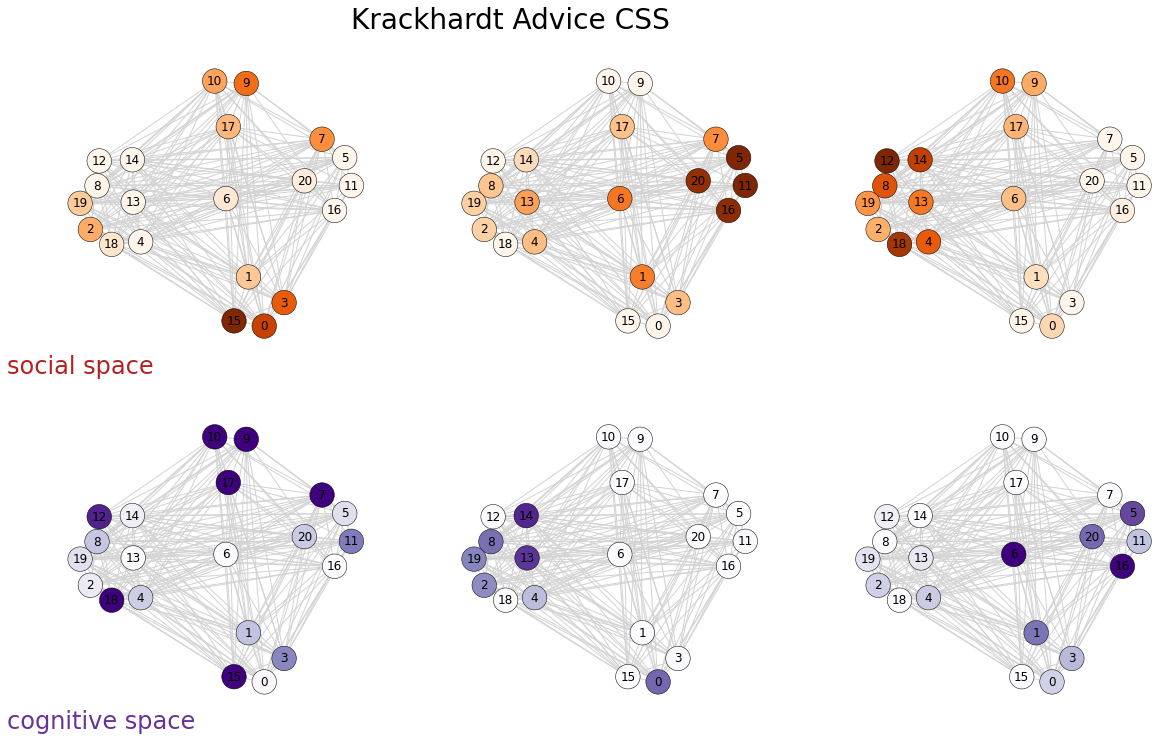

In [28]:
for n in range(1):
    f, axis = plt.subplots(2,3)
    f.set_figheight(12)
    f.set_figwidth(20)
    colors_U1 = ['c'] * len(krack_and)
    colors_U2 = ['c'] * len(krack_and)
    colors_U3 = ['c'] * len(krack_and)
    colors_Y1 = ['c'] * len(krack_and)
    colors_Y2 = ['c'] * len(krack_and)
    colors_Y3 = ['c'] * len(krack_and)
    
    colors_cogsocdiff = ['c'] * len(krack_and)
    Ytwo, Utwo, Vtwo = factors
    cmapOne=plt.get_cmap('Oranges')
    cmapTwo=plt.get_cmap('Purples')
    U_norm = Utwo/np.sum(Utwo, axis = 1, keepdims = True)
    Y_norm = Ytwo/np.sum(Ytwo, axis = 1, keepdims = True)
    for i in range(len(krack_and)):
        colors_U1[i] = cmapOne(U_norm[i, 0])
        colors_U2[i] = cmapOne(U_norm[i, 1])
        colors_U3[i] = cmapOne(U_norm[i, 2])
        colors_Y1[i] = cmapTwo(Y_norm[i, 0])
        colors_Y2[i] = cmapTwo(Y_norm[i, 1])
        colors_Y3[i] = cmapTwo(Y_norm[i, 2])
        colors_cogsocdiff[i] = cmapOne(U_norm[i, 0]-Y_norm[i, 0])

    nx.draw(krack_and_net, posrep,  ax=axis[0,1], node_color=colors_U1, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,1].collections[0].set_edgecolor("k") 
    axis[0,1].collections[0].set_linewidths(0.5)
    nx.draw(krack_and_net, posrep,  ax=axis[0,0], node_color=colors_U3, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,0].collections[0].set_edgecolor("k") 
    axis[0,0].collections[0].set_linewidths(0.5)
    nx.draw(krack_and_net, posrep,  ax=axis[0,2], node_color=colors_U2, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,2].collections[0].set_edgecolor("k") 
    axis[0,2].collections[0].set_linewidths(0.5)

    nx.draw(krack_and_net, posrep,  ax=axis[1,1], node_color=colors_Y2, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,1].collections[0].set_edgecolor("k") 
    axis[1,1].collections[0].set_linewidths(0.5)
    nx.draw(krack_and_net, posrep,  ax=axis[1,2], node_color=colors_Y3, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,2].collections[0].set_edgecolor("k") 
    axis[1,2].collections[0].set_linewidths(0.5)
    nx.draw(krack_and_net, posrep,  ax=axis[1,0], node_color=colors_Y1, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,0].collections[0].set_edgecolor("k") 
    axis[1,0].collections[0].set_linewidths(0.5)
    
    axis[0,0].text(1, 1.2, 'Krackhardt Advice CSS', fontsize = 28, c = 'k')
    axis[0,0].text(-1.5, -1.2, 'social space', fontsize = 24, c = 'firebrick')
    axis[1,0].text(-1.5, -1.2, 'cognitive space', fontsize = 24, c = 'rebeccapurple')
    
    filename = 'kracka_cognet_max_3_3.pdf'
    plt.savefig(filename)

## Krackhardt Advice SCA

In [17]:
core_SCA, factors_SCA, loglike_SCA =  multistart(krack, 3, 3, masked = False, Mask = None, Sym = False, 
                                     NUM_IT = 50, ms_type = 'SCA')

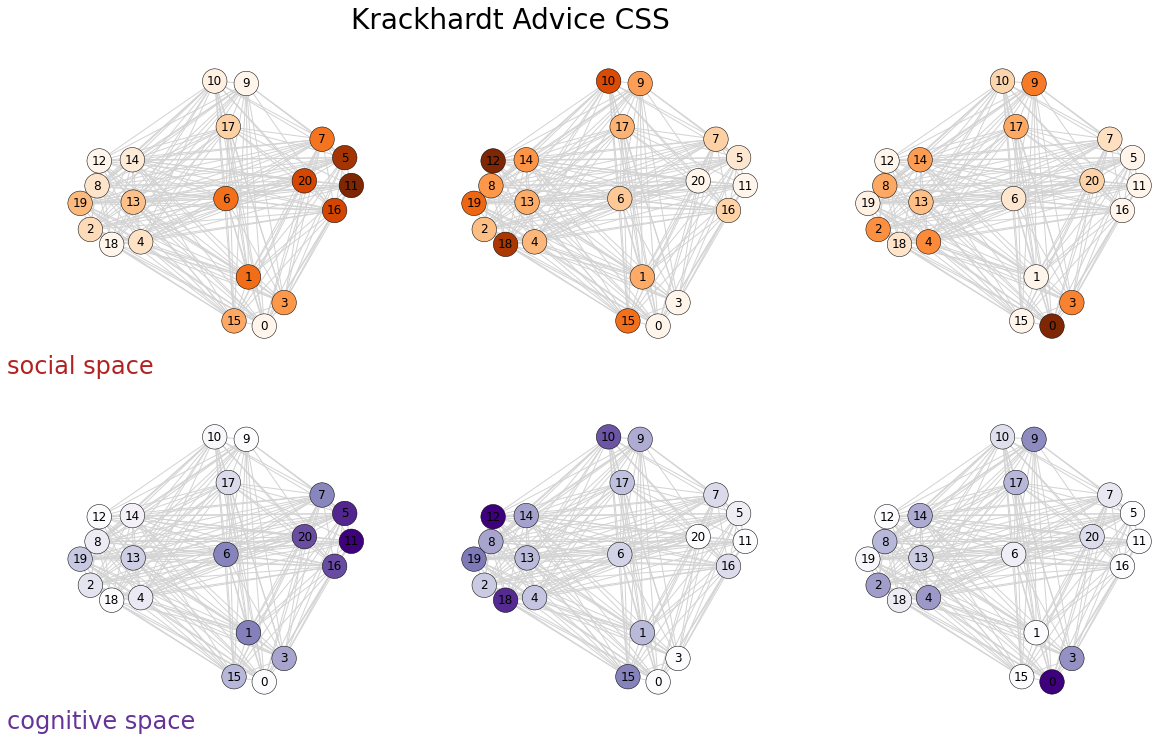

In [19]:
for n in range(1):
    f, axis = plt.subplots(2,3)
    f.set_figheight(12)
    f.set_figwidth(20)
    colors_U1 = ['c'] * len(krack_and)
    colors_U2 = ['c'] * len(krack_and)
    colors_U3 = ['c'] * len(krack_and)
    colors_Y1 = ['c'] * len(krack_and)
    colors_Y2 = ['c'] * len(krack_and)
    colors_Y3 = ['c'] * len(krack_and)
    Ytwo, Utwo, Vtwo = factors_SCA
    cmapOne=plt.get_cmap('Oranges')
    cmapTwo=plt.get_cmap('Purples')
    U_norm = Utwo/np.sum(Utwo, axis = 1, keepdims = True)
    Y_norm = Ytwo/np.sum(Ytwo, axis = 1, keepdims = True)
    for i in range(len(krack_and)):
        colors_U1[i] = cmapOne(U_norm[i, 0])
        colors_U2[i] = cmapOne(U_norm[i, 1])
        colors_U3[i] = cmapOne(U_norm[i, 2])
        colors_Y1[i] = cmapTwo(Y_norm[i, 0])
        colors_Y2[i] = cmapTwo(Y_norm[i, 1])
        colors_Y3[i] = cmapTwo(Y_norm[i, 2])
        colors_cogsocdiff[i] = cmapOne(U_norm[i, 0]-Y_norm[i, 0])

    nx.draw(krack_and_net, posrep,  ax=axis[0,1], node_color=colors_U2, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,1].collections[0].set_edgecolor("k") 
    axis[0,1].collections[0].set_linewidths(0.5)
    nx.draw(krack_and_net, posrep,  ax=axis[0,0], node_color=colors_U1, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,0].collections[0].set_edgecolor("k") 
    axis[0,0].collections[0].set_linewidths(0.5)
    nx.draw(krack_and_net, posrep,  ax=axis[0,2], node_color=colors_U3, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,2].collections[0].set_edgecolor("k") 
    axis[0,2].collections[0].set_linewidths(0.5)
    nx.draw(krack_and_net, posrep,  ax=axis[1,1], node_color=colors_Y2, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,1].collections[0].set_edgecolor("k") 
    axis[1,1].collections[0].set_linewidths(0.5)
    nx.draw(krack_and_net, posrep,  ax=axis[1,2], node_color=colors_Y3, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,2].collections[0].set_edgecolor("k") 
    axis[1,2].collections[0].set_linewidths(0.5)
    nx.draw(krack_and_net, posrep,  ax=axis[1,0], node_color=colors_Y1, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,0].collections[0].set_edgecolor("k") 
    axis[1,0].collections[0].set_linewidths(0.5)
    axis[0,0].text(1, 1.2, 'Krackhardt Advice CSS', fontsize = 28, c = 'k')
    axis[0,0].text(-1.5, -1.2, 'social space', fontsize = 24, c = 'firebrick')
    axis[1,0].text(-1.5, -1.2, 'cognitive space', fontsize = 24, c = 'rebeccapurple')
    
    axis[1,2].axis('off')
    filename = 'kracka_SCA_cognet_max_3_3.pdf'
    plt.savefig(filename, bbox_inches='tight')
    #plt.close()

## Re-writing $\mathcal{G}$ in the basis of person 6, 14, and 11


In [248]:
def Y_interp(factors, r_star = None, verbose = False):
    Y = factors[0]
    ALPHA, C = np.shape(Y)
    
    Y_star = np.zeros_like(Y)
    r_bar = [r for r in range(ALPHA) if r not in r_star]
    Y_rstar = Y[r_star, :]
    Y_rbar = Y[r_bar, :]
    Y_star[r_star, :] = np.eye(C)
    Y_star[r_bar, :] = np.linalg.solve(Y_rstar.T, Y_rbar.T).T
    
    if verbose:
        with np.printoptions(precision = 4, suppress=True):
            print("True Y is ")
            print("")
            print(Y)
            print("")
            print("Y_norm is")
            print("")
            print(Y/np.sum(Y, axis = 1, keepdims = True))
            print("")
            print("row normalized Y_star is")
            print("")
            print(Y_star/np.sum(abs(Y_star), axis = 1, keepdims = True))
            print("")
                
    return Y_star/np.sum(abs(Y_star), axis = 1, keepdims = True)

In [250]:
Ystar = Y_interp(factors, r_star = [14, 6, 10], verbose = True)

True Y is 

[[0.0879 0.509  0.0759]
 [0.1082 0.     0.1086]
 [0.1135 0.2865 0.0324]
 [0.2887 0.0131 0.042 ]
 [0.1578 0.1619 0.0794]
 [0.     0.     0.1294]
 [0.0284 0.     0.3472]
 [0.2167 0.0001 0.0025]
 [0.0877 0.2648 0.0001]
 [0.2445 0.     0.    ]
 [0.1255 0.     0.    ]
 [0.1321 0.0046 0.12  ]
 [0.0579 0.     0.0335]
 [0.0018 0.3311 0.0289]
 [0.0014 0.2603 0.0043]
 [0.0735 0.     0.0098]
 [0.0005 0.     0.1062]
 [0.2343 0.0006 0.    ]
 [0.1705 0.001  0.    ]
 [0.034  0.1436 0.027 ]
 [0.1706 0.     0.2322]]

Y_norm is

[[0.1307 0.7565 0.1129]
 [0.4991 0.     0.5009]
 [0.2625 0.6626 0.0749]
 [0.8395 0.0382 0.1222]
 [0.3955 0.4057 0.1989]
 [0.     0.     1.    ]
 [0.0757 0.     0.9243]
 [0.9881 0.0006 0.0113]
 [0.2488 0.7511 0.0001]
 [1.     0.     0.    ]
 [1.     0.     0.    ]
 [0.5146 0.0178 0.4676]
 [0.6337 0.     0.3663]
 [0.0051 0.915  0.0799]
 [0.0051 0.9788 0.0161]
 [0.8827 0.     0.1173]
 [0.0046 0.     0.9954]
 [0.9975 0.0025 0.    ]
 [0.9944 0.0056 0.    ]
 [0.1661 0.7019

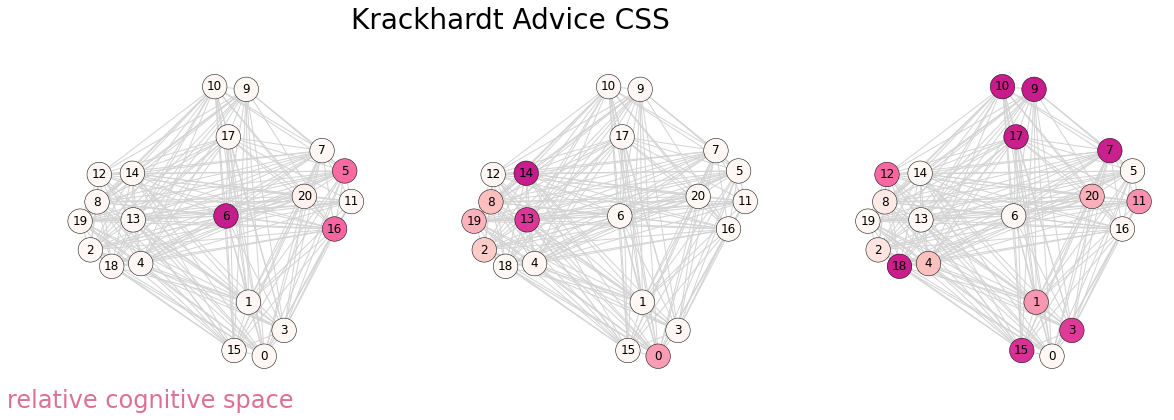

In [245]:
for n in range(1):
    f, axis = plt.subplots(1,3)
    f.set_figheight(6)
    f.set_figwidth(20)
    colors_Y1 = ['c'] * len(krack_and)
    colors_Y2 = ['c'] * len(krack_and)
    colors_Y3 = ['c'] * len(krack_and)
    cmapTwo=plt.get_cmap('RdPu')
    Y_norm = Ystar- 0.32*np.ones(3) # just to make the colour prettier 
    for i in range(len(krack_and)):
        colors_Y1[i] = cmapTwo(Y_norm[i, 0])
        colors_Y2[i] = cmapTwo(Y_norm[i, 1])
        colors_Y3[i] = cmapTwo(Y_norm[i, 2])

    nx.draw(krack_and_net, posrep,  ax=axis[1], node_color=colors_Y1, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1].collections[0].set_edgecolor("k") 
    axis[1].collections[0].set_linewidths(0.5)
    nx.draw(krack_and_net, posrep,  ax=axis[2], node_color=colors_Y3, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[2].collections[0].set_edgecolor("k") 
    axis[2].collections[0].set_linewidths(0.5)
    nx.draw(krack_and_net, posrep,  ax=axis[0], node_color=colors_Y2, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0].collections[0].set_edgecolor("k") 
    axis[0].collections[0].set_linewidths(0.5)
    
    axis[0].text(1, 1.2, 'Krackhardt Advice CSS', fontsize = 28, c = 'k')
    axis[0].text(-1.5, -1.2, 'relative cognitive space', fontsize = 24, c = 'palevioletred')
    
    filename = 'kracka_cognet_rel_3_3.pdf'
    plt.savefig(filename, bbox_inches='tight')
    #plt.close()

# Krackhardt Friendship 

In [20]:
core_fr, factors_fr, loglike_fr =  multistart(krack_f, C = 5, K = 3, masked = False, Mask = None, Sym = False, 
                                     NUM_IT = 50, ms_type = 'reg')

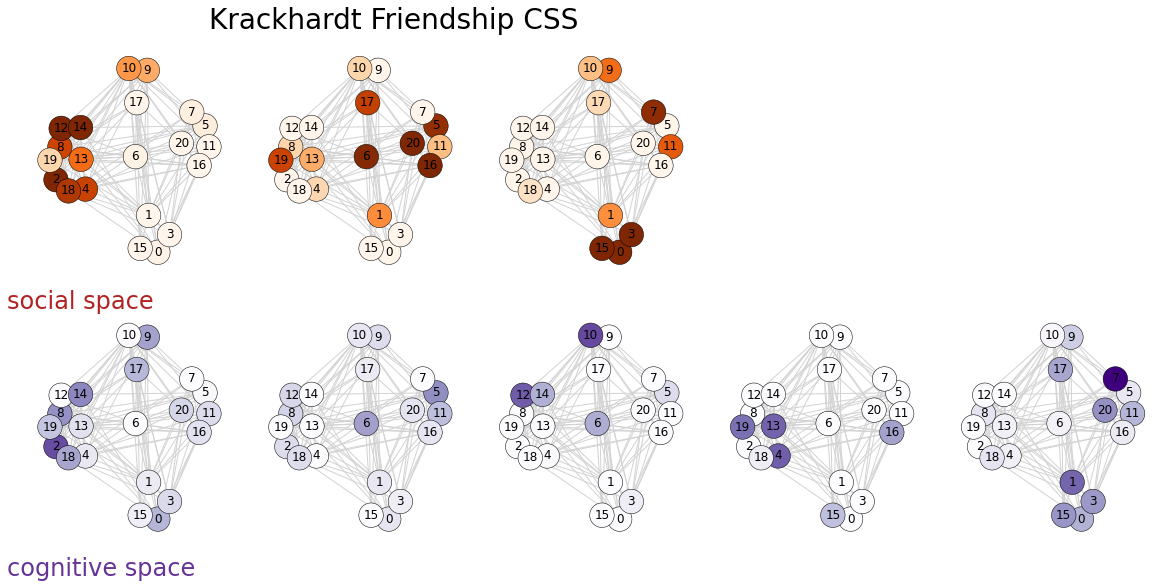

In [25]:

for n in range(1):
    f, axis = plt.subplots(2,5)
    f.set_figheight(9)
    f.set_figwidth(20)
    colors_U1 = ['c'] * len(krackf_and)
    colors_U2 = ['c'] * len(krackf_and)
    colors_U3 = ['c'] * len(krackf_and)
    colors_Y1 = ['c'] * len(krackf_and)
    colors_Y2 = ['c'] * len(krackf_and)
    colors_Y3 = ['c'] * len(krackf_and)
    colors_Y4 = ['c'] * len(krackf_and)
    colors_Y4 = ['c'] * len(krackf_and)
    colors_Y5 = ['c'] * len(krackf_and)
    Ytwo, Utwo, Vtwo = factors_fr
    cmapOne=plt.get_cmap('Oranges')
    cmapTwo=plt.get_cmap('Purples')
    U_norm = Utwo/np.sum(Utwo, axis = 1, keepdims = True)
    Y_norm = Ytwo/np.sum(Ytwo, axis = 1, keepdims = True)
    for i in range(len(krackf_and)):
        colors_U1[i] = cmapOne(U_norm[i, 0])
        colors_U2[i] = cmapOne(U_norm[i, 1])
        colors_U3[i] = cmapOne(U_norm[i, 2])
        colors_Y1[i] = cmapTwo(Y_norm[i, 0])
        colors_Y2[i] = cmapTwo(Y_norm[i, 1])
        colors_Y3[i] = cmapTwo(Y_norm[i, 2])
        colors_Y4[i] = cmapTwo(Y_norm[i, 3])
        colors_Y5[i] = cmapTwo(Y_norm[i, 4])
        colors_cogsocdiff[i] = cmapOne(U_norm[i, 0]-Y_norm[i, 0])

    nx.draw(krackf_Network, posrep,  ax=axis[0,1], node_color=colors_U1, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,1].collections[0].set_edgecolor("k") 
    axis[0,1].collections[0].set_linewidths(0.5)
    nx.draw(krackf_Network, posrep,  ax=axis[0,0], node_color=colors_U2, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,0].collections[0].set_edgecolor("k") 
    axis[0,0].collections[0].set_linewidths(0.5)
    nx.draw(krackf_Network, posrep,  ax=axis[0,2], node_color=colors_U3, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,2].collections[0].set_edgecolor("k") 
    axis[0,2].collections[0].set_linewidths(0.5)
    nx.draw(krackf_Network, posrep,  ax=axis[1,1], node_color=colors_Y1, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,1].collections[0].set_edgecolor("k") 
    axis[1,1].collections[0].set_linewidths(0.5)
    nx.draw(krackf_Network, posrep,  ax=axis[1,2], node_color=colors_Y3, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,2].collections[0].set_edgecolor("k") 
    axis[1,2].collections[0].set_linewidths(0.5)
    nx.draw(krackf_Network, posrep,  ax=axis[1,0], node_color=colors_Y2, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,0].collections[0].set_edgecolor("k") 
    axis[1,0].collections[0].set_linewidths(0.5)
    nx.draw(krackf_Network, posrep,  ax=axis[1,3], node_color=colors_Y4, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,3].collections[0].set_edgecolor("k") 
    axis[1,3].collections[0].set_linewidths(0.5)
    
    nx.draw(krackf_Network, posrep,  ax=axis[1,4], node_color=colors_Y5, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,4].collections[0].set_edgecolor("k") 
    axis[1,4].collections[0].set_linewidths(0.5)
    
    axis[0,0].text(1, 1.2, 'Krackhardt Friendship CSS', fontsize = 28, c = 'k')
    axis[0,0].text(-1.5, -1.4, 'social space', fontsize = 24, c = 'firebrick')
    axis[1,0].text(-1.5, -1.4, 'cognitive space', fontsize = 24, c = 'rebeccapurple')
    
    axis[0, 3].axis('off')
    axis[0, 4].axis('off')
    filename = 'krackf_cognet_max_3_5.pdf'
    plt.savefig(filename, bbox_inches='tight')

In [24]:
core_fr_SCA, factors_fr_SCA, loglike_fr_SCA =  multistart(krack_f, C = 3, K = 3, masked = False, Mask = None, Sym = False, 
                                     NUM_IT = 50, ms_type = 'SCA')

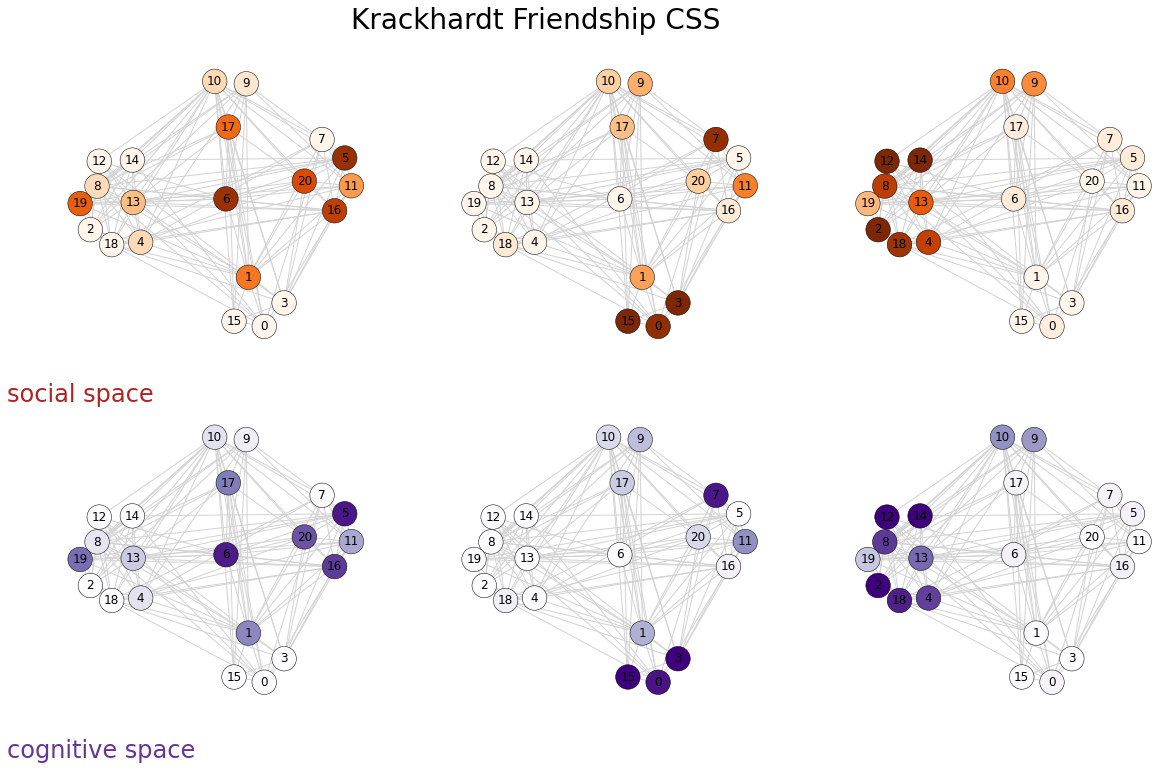

In [28]:

for n in range(1):
    f, axis = plt.subplots(2,3)
    f.set_figheight(12)
    f.set_figwidth(20)
    colors_U1 = ['c'] * len(krackf_and)
    colors_U2 = ['c'] * len(krackf_and)
    colors_U3 = ['c'] * len(krackf_and)
    colors_Y1 = ['c'] * len(krackf_and)
    colors_Y2 = ['c'] * len(krackf_and)
    colors_Y3 = ['c'] * len(krackf_and)
    Ytwo, Utwo, Vtwo = factors_fr_SCA
    cmapOne=plt.get_cmap('Oranges')
    cmapTwo=plt.get_cmap('Purples')
    U_norm = Utwo/np.sum(Utwo, axis = 1, keepdims = True)
    Y_norm = Ytwo/np.sum(Ytwo, axis = 1, keepdims = True)
    for i in range(len(krackf_and)):
        colors_U1[i] = cmapOne(U_norm[i, 0])
        colors_U2[i] = cmapOne(U_norm[i, 1])
        colors_U3[i] = cmapOne(U_norm[i, 2])
        colors_Y1[i] = cmapTwo(Y_norm[i, 0])
        colors_Y2[i] = cmapTwo(Y_norm[i, 1])
        colors_Y3[i] = cmapTwo(Y_norm[i, 2])

        colors_cogsocdiff[i] = cmapOne(U_norm[i, 0]-Y_norm[i, 0])

    nx.draw(krackf_Network, posrep,  ax=axis[0,1], node_color=colors_U1, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,1].collections[0].set_edgecolor("k") 
    axis[0,1].collections[0].set_linewidths(0.5)
    nx.draw(krackf_Network, posrep,  ax=axis[0,0], node_color=colors_U2, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,0].collections[0].set_edgecolor("k") 
    axis[0,0].collections[0].set_linewidths(0.5)
    nx.draw(krackf_Network, posrep,  ax=axis[0,2], node_color=colors_U3, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,2].collections[0].set_edgecolor("k") 
    axis[0,2].collections[0].set_linewidths(0.5)
    nx.draw(krackf_Network, posrep,  ax=axis[1,1], node_color=colors_Y1, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,1].collections[0].set_edgecolor("k") 
    axis[1,1].collections[0].set_linewidths(0.5)
    nx.draw(krackf_Network, posrep,  ax=axis[1,2], node_color=colors_Y3, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,2].collections[0].set_edgecolor("k") 
    axis[1,2].collections[0].set_linewidths(0.5)
    nx.draw(krackf_Network, posrep,  ax=axis[1,0], node_color=colors_Y2, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,0].collections[0].set_edgecolor("k") 
    axis[1,0].collections[0].set_linewidths(0.5)

    
    axis[0,0].text(1, 1.2, 'Krackhardt Friendship CSS', fontsize = 28, c = 'k')
    axis[0,0].text(-1.5, -1.4, 'social space', fontsize = 24, c = 'firebrick')
    axis[1,0].text(-1.5, -1.4, 'cognitive space', fontsize = 24, c = 'rebeccapurple')
    
    filename = 'krackf_cognet_max_SCA.pdf'
    plt.savefig(filename, bbox_inches='tight')

# Hunter Advice

In [29]:
core_huntera, factors_huntera, loglike_huntera =  multistart(hunter_a[-1], C = 4, K = 2, masked = False, Mask = None, Sym = False, 
                                     NUM_IT = 50, ms_type = 'reg')

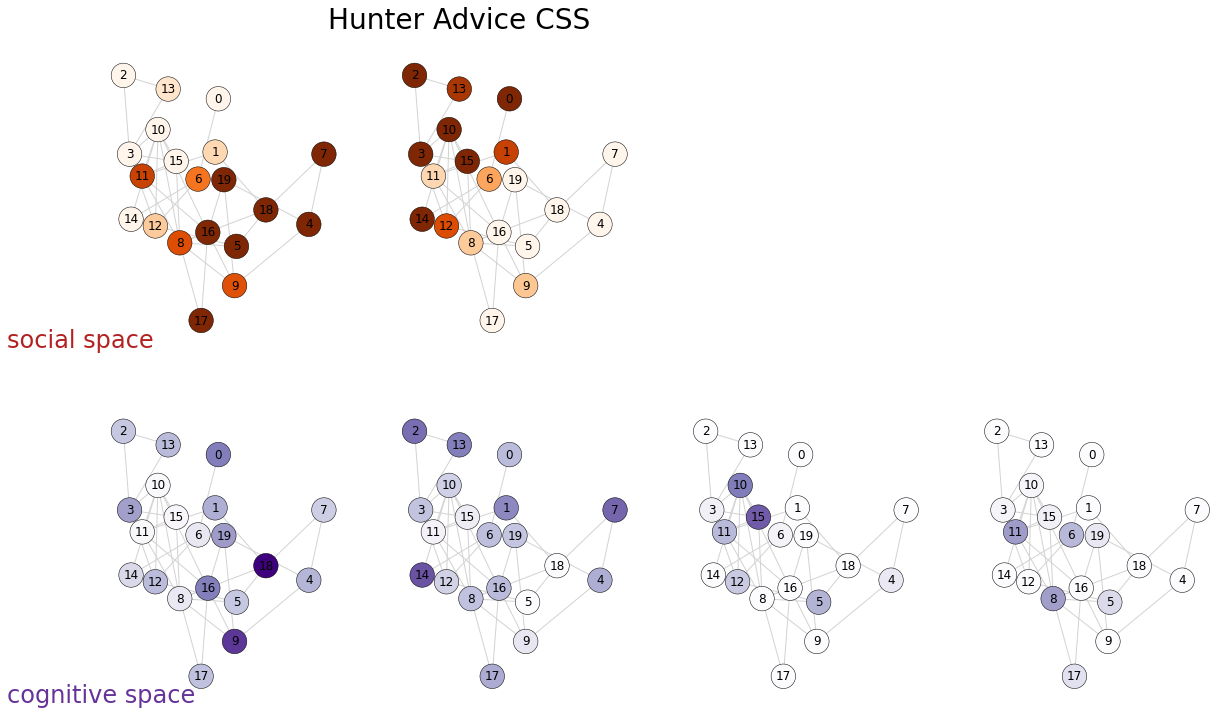

In [76]:

for n in range(1):
    f, axis = plt.subplots(2,4)
    f.set_figheight(12)
    f.set_figwidth(20)
    colors_U1 = ['c'] * len(advice_truth_6)
    colors_U2 = ['c'] * len(advice_truth_6)
    colors_Y1 = ['c'] * len(advice_truth_6)
    colors_Y2 = ['c'] * len(advice_truth_6)
    colors_Y3 = ['c'] * len(advice_truth_6)
    colors_Y4 = ['c'] * len(advice_truth_6)
    colors_Y4 = ['c'] * len(advice_truth_6)
    Ytwo, Utwo, Vtwo = factors_huntera
    cmapOne=plt.get_cmap('Oranges')
    cmapTwo=plt.get_cmap('Purples')
    U_norm = Utwo/np.sum(Utwo, axis = 1, keepdims = True)
    Y_norm = Ytwo/np.sum(Ytwo, axis = 1, keepdims = True)
    for i in range(len(friend_truth_6)):
        colors_U1[i] = cmapOne(U_norm[i, 0])
        colors_U2[i] = cmapOne(U_norm[i, 1])
        colors_Y1[i] = cmapTwo(Y_norm[i, 0])
        colors_Y2[i] = cmapTwo(Y_norm[i, 1])
        colors_Y3[i] = cmapTwo(Y_norm[i, 2])
        colors_Y4[i] = cmapTwo(Y_norm[i, 3])
        colors_cogsocdiff[i] = cmapOne(U_norm[i, 0]-Y_norm[i, 0])

    nx.draw(ad_network, pos,  ax=axis[0,1], node_color=colors_U1, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,1].collections[0].set_edgecolor("k") 
    axis[0,1].collections[0].set_linewidths(0.5)
    nx.draw(ad_network, pos,  ax=axis[0,0], node_color=colors_U2, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,0].collections[0].set_edgecolor("k") 
    axis[0,0].collections[0].set_linewidths(0.5)
    nx.draw(ad_network, pos,  ax=axis[1,1], node_color=colors_Y1, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,1].collections[0].set_edgecolor("k") 
    axis[1,1].collections[0].set_linewidths(0.5)
    nx.draw(ad_network, pos,  ax=axis[1,2], node_color=colors_Y3, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,2].collections[0].set_edgecolor("k") 
    axis[1,2].collections[0].set_linewidths(0.5)
    nx.draw(ad_network, pos,  ax=axis[1,0], node_color=colors_Y4, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,0].collections[0].set_edgecolor("k") 
    axis[1,0].collections[0].set_linewidths(0.5)
    nx.draw(ad_network, pos,  ax=axis[1,3], node_color=colors_Y2, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,3].collections[0].set_edgecolor("k") 
    axis[1,3].collections[0].set_linewidths(0.5)
    
    axis[0,0].text(1, 1.2, 'Hunter Advice CSS', fontsize = 28, c = 'k')
    axis[0,0].text(-1.5, -1.2, 'social space', fontsize = 24, c = 'firebrick')
    axis[1,0].text(-1.5, -1.2, 'cognitive space', fontsize = 24, c = 'rebeccapurple')
    
    axis[0, 2].axis('off')
    axis[0, 3].axis('off')
    filename = 'huntera_cognet_max_2_4.pdf'
    plt.savefig(filename, bbox_inches='tight')

In [77]:
core_huntera_SCA, factors_huntera_SCA, loglike_huntera_SCA =  multistart(hunter_a[-1], C = 2, K = 2, masked = False, Mask = None, Sym = False, 
                                     NUM_IT = 50, ms_type = 'SCA')

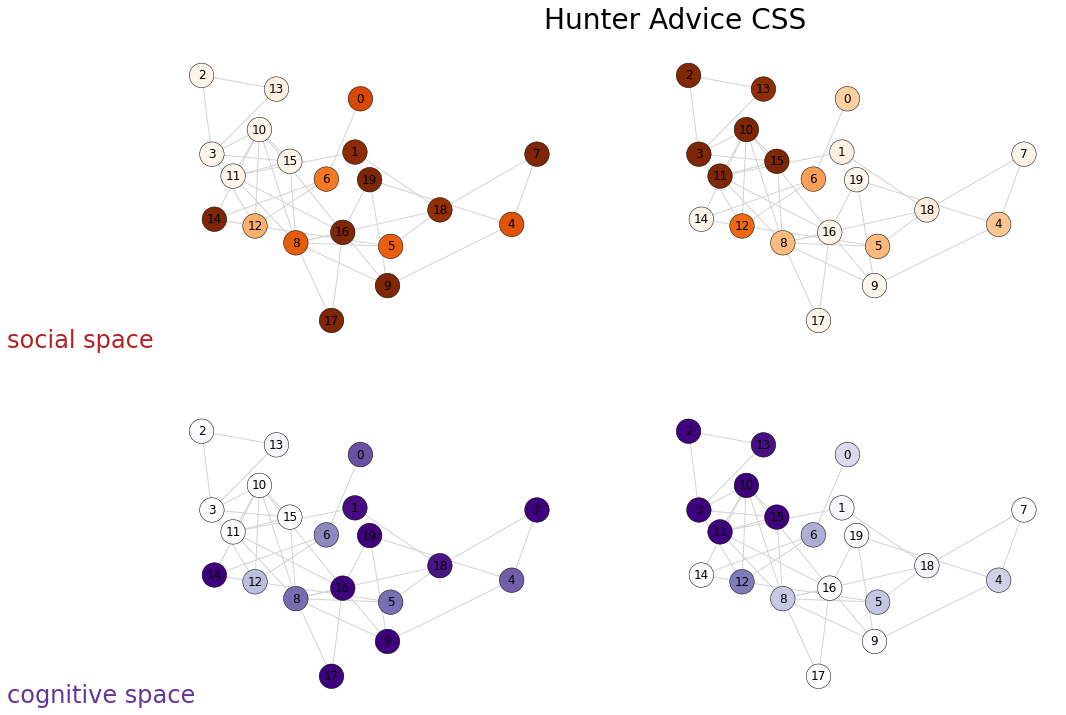

In [82]:

for n in range(1):
    f, axis = plt.subplots(2,2)
    f.set_figheight(12)
    f.set_figwidth(16)
    colors_U1 = ['c'] * len(advice_truth_6)
    colors_U2 = ['c'] * len(advice_truth_6)
    colors_Y1 = ['c'] * len(advice_truth_6)
    colors_Y2 = ['c'] * len(advice_truth_6)
    Ytwo, Utwo, Vtwo = factors_huntera_SCA
    cmapOne=plt.get_cmap('Oranges')
    cmapTwo=plt.get_cmap('Purples')
    U_norm = Utwo/np.sum(Utwo, axis = 1, keepdims = True)
    Y_norm = Ytwo/np.sum(Ytwo, axis = 1, keepdims = True)
    for i in range(len(friend_truth_6)):
        colors_U1[i] = cmapOne(U_norm[i, 0])
        colors_U2[i] = cmapOne(U_norm[i, 1])
        colors_Y1[i] = cmapTwo(Y_norm[i, 0])
        colors_Y2[i] = cmapTwo(Y_norm[i, 1])
        colors_cogsocdiff[i] = cmapOne(U_norm[i, 0]-Y_norm[i, 0])

    nx.draw(ad_network, pos,  ax=axis[0,1], node_color=colors_U1, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,1].collections[0].set_edgecolor("k") 
    axis[0,1].collections[0].set_linewidths(0.5)
    nx.draw(ad_network, pos,  ax=axis[0,0], node_color=colors_U2, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,0].collections[0].set_edgecolor("k") 
    axis[0,0].collections[0].set_linewidths(0.5)
    nx.draw(ad_network, pos,  ax=axis[1,1], node_color=colors_Y1, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,1].collections[0].set_edgecolor("k") 
    axis[1,1].collections[0].set_linewidths(0.5)
    nx.draw(ad_network, pos,  ax=axis[1,0], node_color=colors_Y2, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,0].collections[0].set_edgecolor("k") 
    axis[1,0].collections[0].set_linewidths(0.5)
    
    axis[0,0].text(1, 1.2, 'Hunter Advice CSS', fontsize = 28, c = 'k')
    axis[0,0].text(-1.5, -1.2, 'social space', fontsize = 24, c = 'firebrick')
    axis[1,0].text(-1.5, -1.2, 'cognitive space', fontsize = 24, c = 'rebeccapurple')
    
    filename = 'huntera_cognet_max_SCA.pdf'
    plt.savefig(filename,bbox_inches='tight')

# Hunter Friendship

In [83]:
core_hunterf, factors_hunterf, loglike_hunterf =  multistart(hunter_f[-1], C = 3, K = 2, masked = False, Mask = None, Sym = False, 
                                     NUM_IT = 50, ms_type = 'reg')

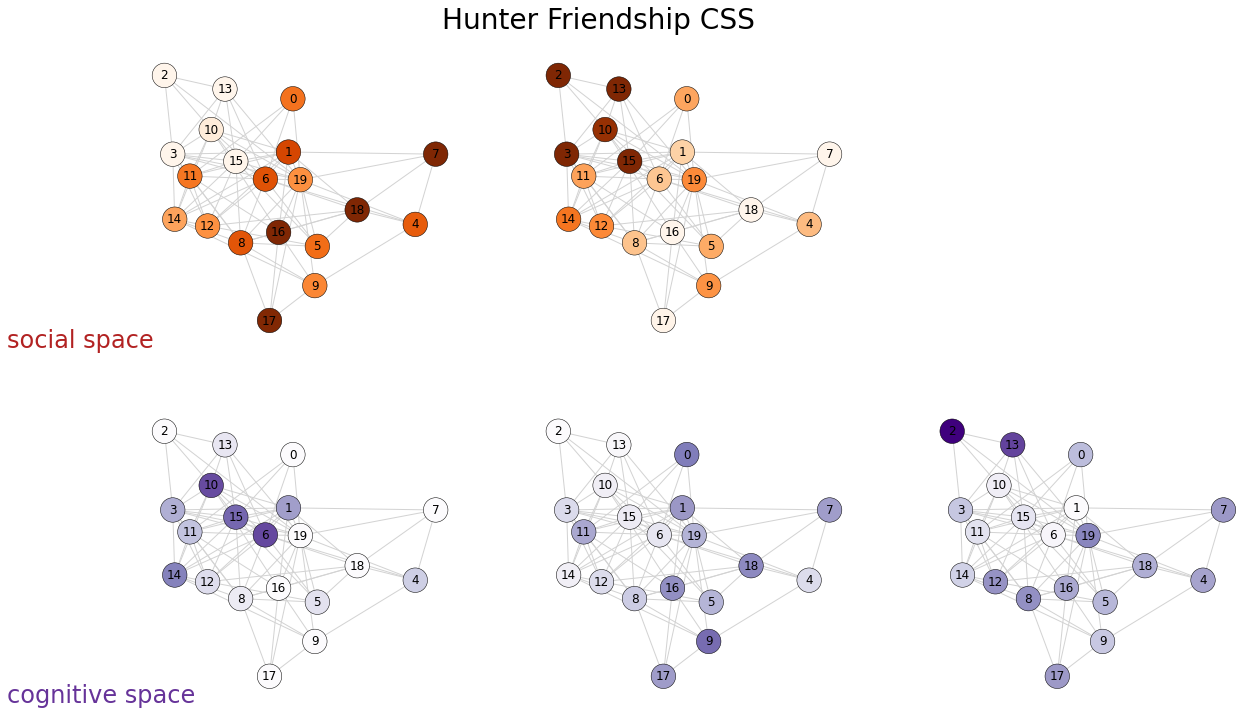

In [85]:

for n in range(1):
    f, axis = plt.subplots(2,3)
    f.set_figheight(12)
    f.set_figwidth(20)
    colors_U1 = ['c'] * len(advice_truth_6)
    colors_U2 = ['c'] * len(advice_truth_6)
    colors_Y1 = ['c'] * len(advice_truth_6)
    colors_Y2 = ['c'] * len(advice_truth_6)


    Ytwo, Utwo, Vtwo = factors_hunterf
    cmapOne=plt.get_cmap('Oranges')
    cmapTwo=plt.get_cmap('Purples')
    U_norm = Utwo/np.sum(Utwo, axis = 1, keepdims = True)
    Y_norm = Ytwo/np.sum(Ytwo, axis = 1, keepdims = True)
    for i in range(len(friend_truth_6)):
        colors_U1[i] = cmapOne(U_norm[i, 0])
        colors_U2[i] = cmapOne(U_norm[i, 1])
        colors_Y1[i] = cmapTwo(Y_norm[i, 0])
        colors_Y2[i] = cmapTwo(Y_norm[i, 1])
        colors_Y3[i] = cmapTwo(Y_norm[i, 2])
        colors_cogsocdiff[i] = cmapOne(U_norm[i, 0]-Y_norm[i, 0])

    nx.draw(fr_network, pos,  ax=axis[0,1], node_color=colors_U1, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,1].collections[0].set_edgecolor("k") 
    axis[0,1].collections[0].set_linewidths(0.5)
    nx.draw(fr_network, pos,  ax=axis[0,0], node_color=colors_U2, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,0].collections[0].set_edgecolor("k") 
    axis[0,0].collections[0].set_linewidths(0.5)
    nx.draw(fr_network, pos,  ax=axis[1,1], node_color=colors_Y1, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,1].collections[0].set_edgecolor("k") 
    axis[1,1].collections[0].set_linewidths(0.5)
    nx.draw(fr_network, pos,  ax=axis[1,2], node_color=colors_Y3, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,2].collections[0].set_edgecolor("k") 
    axis[1,2].collections[0].set_linewidths(0.5)
    nx.draw(fr_network, pos,  ax=axis[1,0], node_color=colors_Y2, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,0].collections[0].set_edgecolor("k") 
    axis[1,0].collections[0].set_linewidths(0.5)
    
    axis[0,0].text(1, 1.2, 'Hunter Friendship CSS', fontsize = 28, c = 'k')
    axis[0,0].text(-1.5, -1.2, 'social space', fontsize = 24, c = 'firebrick')
    axis[1,0].text(-1.5, -1.2, 'cognitive space', fontsize = 24, c = 'rebeccapurple')
    axis[0, 2].axis('off')
    filename = 'hunterf_cognet_max_2_3.pdf'
    plt.savefig(filename, bbox_inches='tight')
    #plt.close()

In [87]:
core_hunterf_SCA, factors_hunterf_SCA, loglike_hunterf_SCA =  multistart(hunter_f[-1], C = 2, K = 2, masked = False, Mask = None, Sym = False, 
                                     NUM_IT = 50, ms_type = 'SCA')

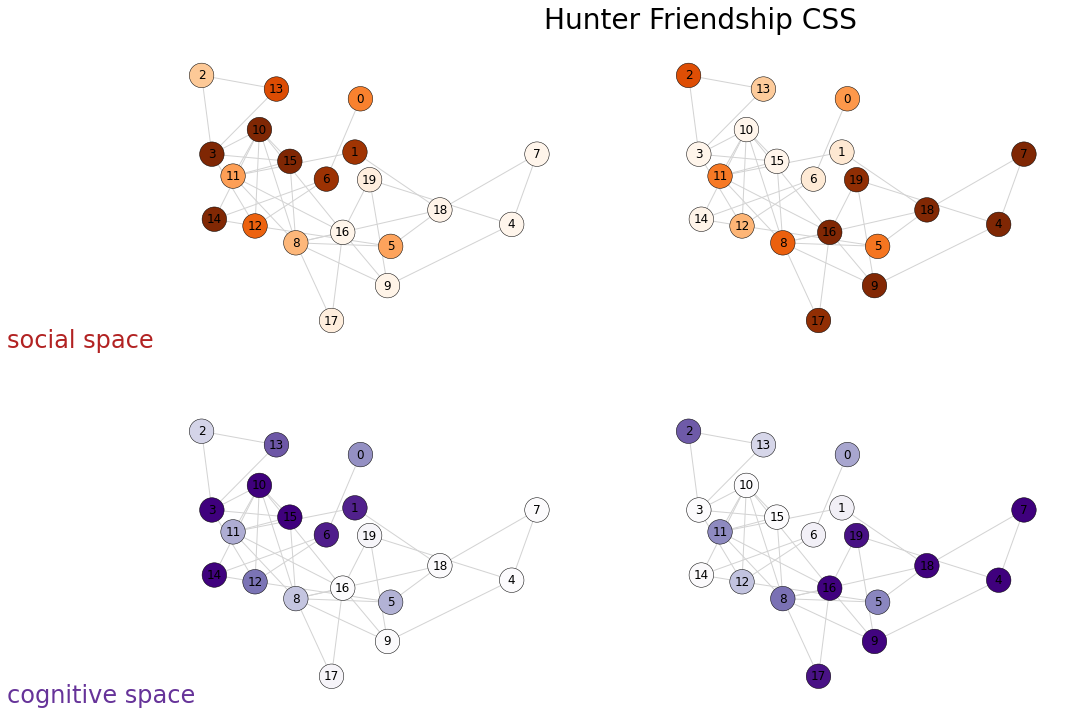

In [89]:

for n in range(1):
    f, axis = plt.subplots(2,2)
    f.set_figheight(12)
    f.set_figwidth(16)
    colors_U1 = ['c'] * len(advice_truth_6)
    colors_U2 = ['c'] * len(advice_truth_6)
    colors_Y1 = ['c'] * len(advice_truth_6)
    colors_Y2 = ['c'] * len(advice_truth_6)
    Ytwo, Utwo, Vtwo = factors_hunterf_SCA
    cmapOne=plt.get_cmap('Oranges')
    cmapTwo=plt.get_cmap('Purples')
    U_norm = Utwo/np.sum(Utwo, axis = 1, keepdims = True)
    Y_norm = Ytwo/np.sum(Ytwo, axis = 1, keepdims = True)
    for i in range(len(friend_truth_6)):
        colors_U1[i] = cmapOne(U_norm[i, 0])
        colors_U2[i] = cmapOne(U_norm[i, 1])
        colors_Y1[i] = cmapTwo(Y_norm[i, 0])
        colors_Y2[i] = cmapTwo(Y_norm[i, 1])
        colors_cogsocdiff[i] = cmapOne(U_norm[i, 0]-Y_norm[i, 0])

    nx.draw(ad_network, pos,  ax=axis[0,1], node_color=colors_U1, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,1].collections[0].set_edgecolor("k") 
    axis[0,1].collections[0].set_linewidths(0.5)
    nx.draw(ad_network, pos,  ax=axis[0,0], node_color=colors_U2, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,0].collections[0].set_edgecolor("k") 
    axis[0,0].collections[0].set_linewidths(0.5)
    nx.draw(ad_network, pos,  ax=axis[1,1], node_color=colors_Y1, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,1].collections[0].set_edgecolor("k") 
    axis[1,1].collections[0].set_linewidths(0.5)
    nx.draw(ad_network, pos,  ax=axis[1,0], node_color=colors_Y2, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,0].collections[0].set_edgecolor("k") 
    axis[1,0].collections[0].set_linewidths(0.5)
    
    axis[0,0].text(1, 1.2, 'Hunter Friendship CSS', fontsize = 28, c = 'k')
    axis[0,0].text(-1.5, -1.2, 'social space', fontsize = 24, c = 'firebrick')
    axis[1,0].text(-1.5, -1.2, 'cognitive space', fontsize = 24, c = 'rebeccapurple')
    
    filename = 'hunterf_cognet_max_SCA.pdf'
    plt.savefig(filename,bbox_inches='tight')
    #plt.close()